<a href="https://colab.research.google.com/github/ChengyangHuang/Personalized_Regression/blob/main/Simulation_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

np.random.seed(0)

def generate_data(N, P, K, sigma_eps):
    X = np.random.uniform(-1, 1, size=(N, P))
    U = np.random.uniform(0, 1, size=(N, K))
    a = (np.abs(U-0.5)>0.25) + 0.1*np.sin(3*np.pi*U)
    theta = np.concatenate((U, a), axis=1)

    w = np.random.normal(0, sigma_eps, size=(N, K))
    # Y = np.diag(np.dot(X, theta.T)).reshape((N, K)) + w
    Y = np.sum(np.multiply(X, theta), axis=1, keepdims=True)
    return X, Y, theta, U 

def plot_parameters(theta_gt, theta_est):
    fig, ax = plt.subplots(1)
    ax.scatter(theta_gt[:, 0], theta_gt[:, 1])
    ax.scatter(theta_est[:, 0], theta_est[:, 1])
    return fig, ax

In [123]:
import torch
from torch.autograd import Variable

class PR():
    def __init__(self, theta_pop, dataset, args):
        self.sigma_theta = args.sigma_theta
        self.lambd = 0 #TODO
        self.gamma = 0 #TODO
        self.nu = 0 #TODO
        self.alpha = args.learning_rate
        self.c = args.lr_decay
        self.q = args.latent_dim

        self.theta_pop = torch.from_numpy(theta_pop)
        self.p = self.theta_pop.shape[0]

        X_train, y_train, theta_train, U_train = dataset
        self.X_train = torch.from_numpy(X_train)
        self.y_train = torch.from_numpy(y_train)
        self.U_train = torch.from_numpy(U_train)
        self.theta_train = torch.from_numpy(theta_train)

        self.n = self.X_train.shape[0]
        self.k = self.U_train.shape[1]

        PI = np.random.multivariate_normal(theta_pop, self.sigma_theta*np.eye(self.p), size=self.n)
        self.PI = torch.from_numpy(PI)
        self.Z, self.Q = self.__init_ZnQ(PI)
        print("Z shape: ", self.Z.shape)
        print("Q shape: ", self.Q.shape)
        rec = torch.mm(self.Z, self.Q)
        plot_parameters(self.theta_train, rec)
        print((rec - self.PI).sum())
        self.phi = torch.ones((self.k, ))


    def train(self, n_epoch=5):
        for _ in range(n_epoch):
            Z = self.Z.clone().requires_grad_(True)
            Q = self.Q.clone().requires_grad_(True)
            phi = self.phi.clone().requires_grad_(True)

            # Calculate Loss
            l_loss, l_grad = self.__sample_specific_loss()
            print(l_grad.shape)
            D_loss = self.__distance_matching_regularizer(Z, phi)
            psi_loss = 0 #TODO
            loss = l_loss + D_loss + psi_loss

            # Update phi
            loss.backward()
            self.phi -= self.alpha * phi.grad

            # Update Z
            alpha_cust = self.alpha / torch.linalg.norm(self.PI-self.theta_pop, 
                                                        float('inf'), dim=1, keepdim=True)
            print(alpha_cust.shape)
            print(Z.grad.shape)
            self.Z -= alpha_cust * (Z.grad + torch.mm(l_grad, Q.T + 0)) #TODO

            # Update Q
            self.Q -= self.alpha #TODO

            # Update alpha
            self.alpha *= self.c

            # Update theta, PI
            self.PI = torch.mm(self.Z, self.Q)

            # plot_parameters(self.theta_train, self.PI)
            # plt.show()
        
    def __init_ZnQ(self, PI):
        pca = PCA(n_components=self.q, whiten=False)
        Z = pca.fit_transform(PI)
        Q = pca.components_
        return torch.from_numpy(Z), torch.from_numpy(Q)
    

    def __distance_matching_regularizer(self, Z, phi):
        #TODO
        J_set = []
        return phi*Z.mean()

    def __parameter_regularizer(self):
        #TODO
        pass
        # return psi_loss, psi_grad
    
    def __sample_specific_loss(self):
        #TOCHECK
        diff = self.y_train - (self.X_train * self.PI).sum(dim=1, keepdim=True)
        l_loss = (0.5 * diff ** 2).sum()
        l_grad = -self.X_train * diff.repeat(1, 2)
        return l_loss, l_grad

Z shape:  torch.Size([2000, 1])
Q shape:  torch.Size([1, 2])
tensor(-1976.5624, dtype=torch.float64)
torch.Size([2000, 2])
torch.Size([2000, 1])
torch.Size([2000, 1])


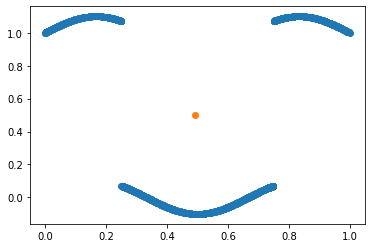

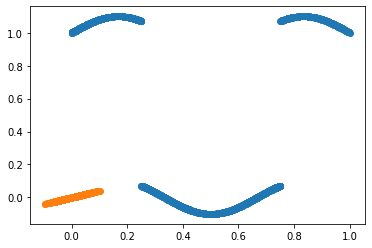

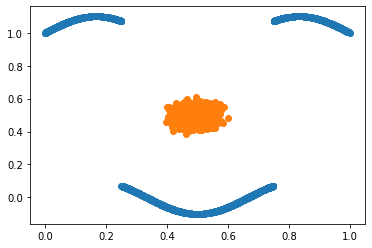

In [124]:
class Data_Arguments():
    N_train = int(2500 * 0.8)
    N_test = int(2500 * 0.2)
    P = 2
    K = 1
    sigma_eps = 0.001

class PR_Arguments():
    sigma_theta = 0.001
    learning_rate = 4e-3
    lr_decay = 1-1e-4
    latent_dim = 1
    n_epoch = 1

def main():
    args = Data_Arguments()
    
    X_train, y_train, theta_train, U_train  = generate_data(args.N_train, args.P, args.K, args.sigma_eps)
    X_test, y_test, theta_test, U_test = generate_data(args.N_test, args.P, args.K, args.sigma_eps)

    dataset_train = (X_train, y_train, theta_train, U_train)

    ## Linear Regression
    lr = LinearRegression().fit(X_train, y_train)
    theta_lr = np.array(lr.coef_)
    plot_parameters(theta_train, theta_lr)

    ## Personalized Regression
    pr_args = PR_Arguments()
    pr = PR(theta_lr.squeeze(), dataset_train, pr_args)
    plot_parameters(theta_train, pr.PI)
    pr.train(pr_args.n_epoch)
    

if __name__ == "__main__":
    main()